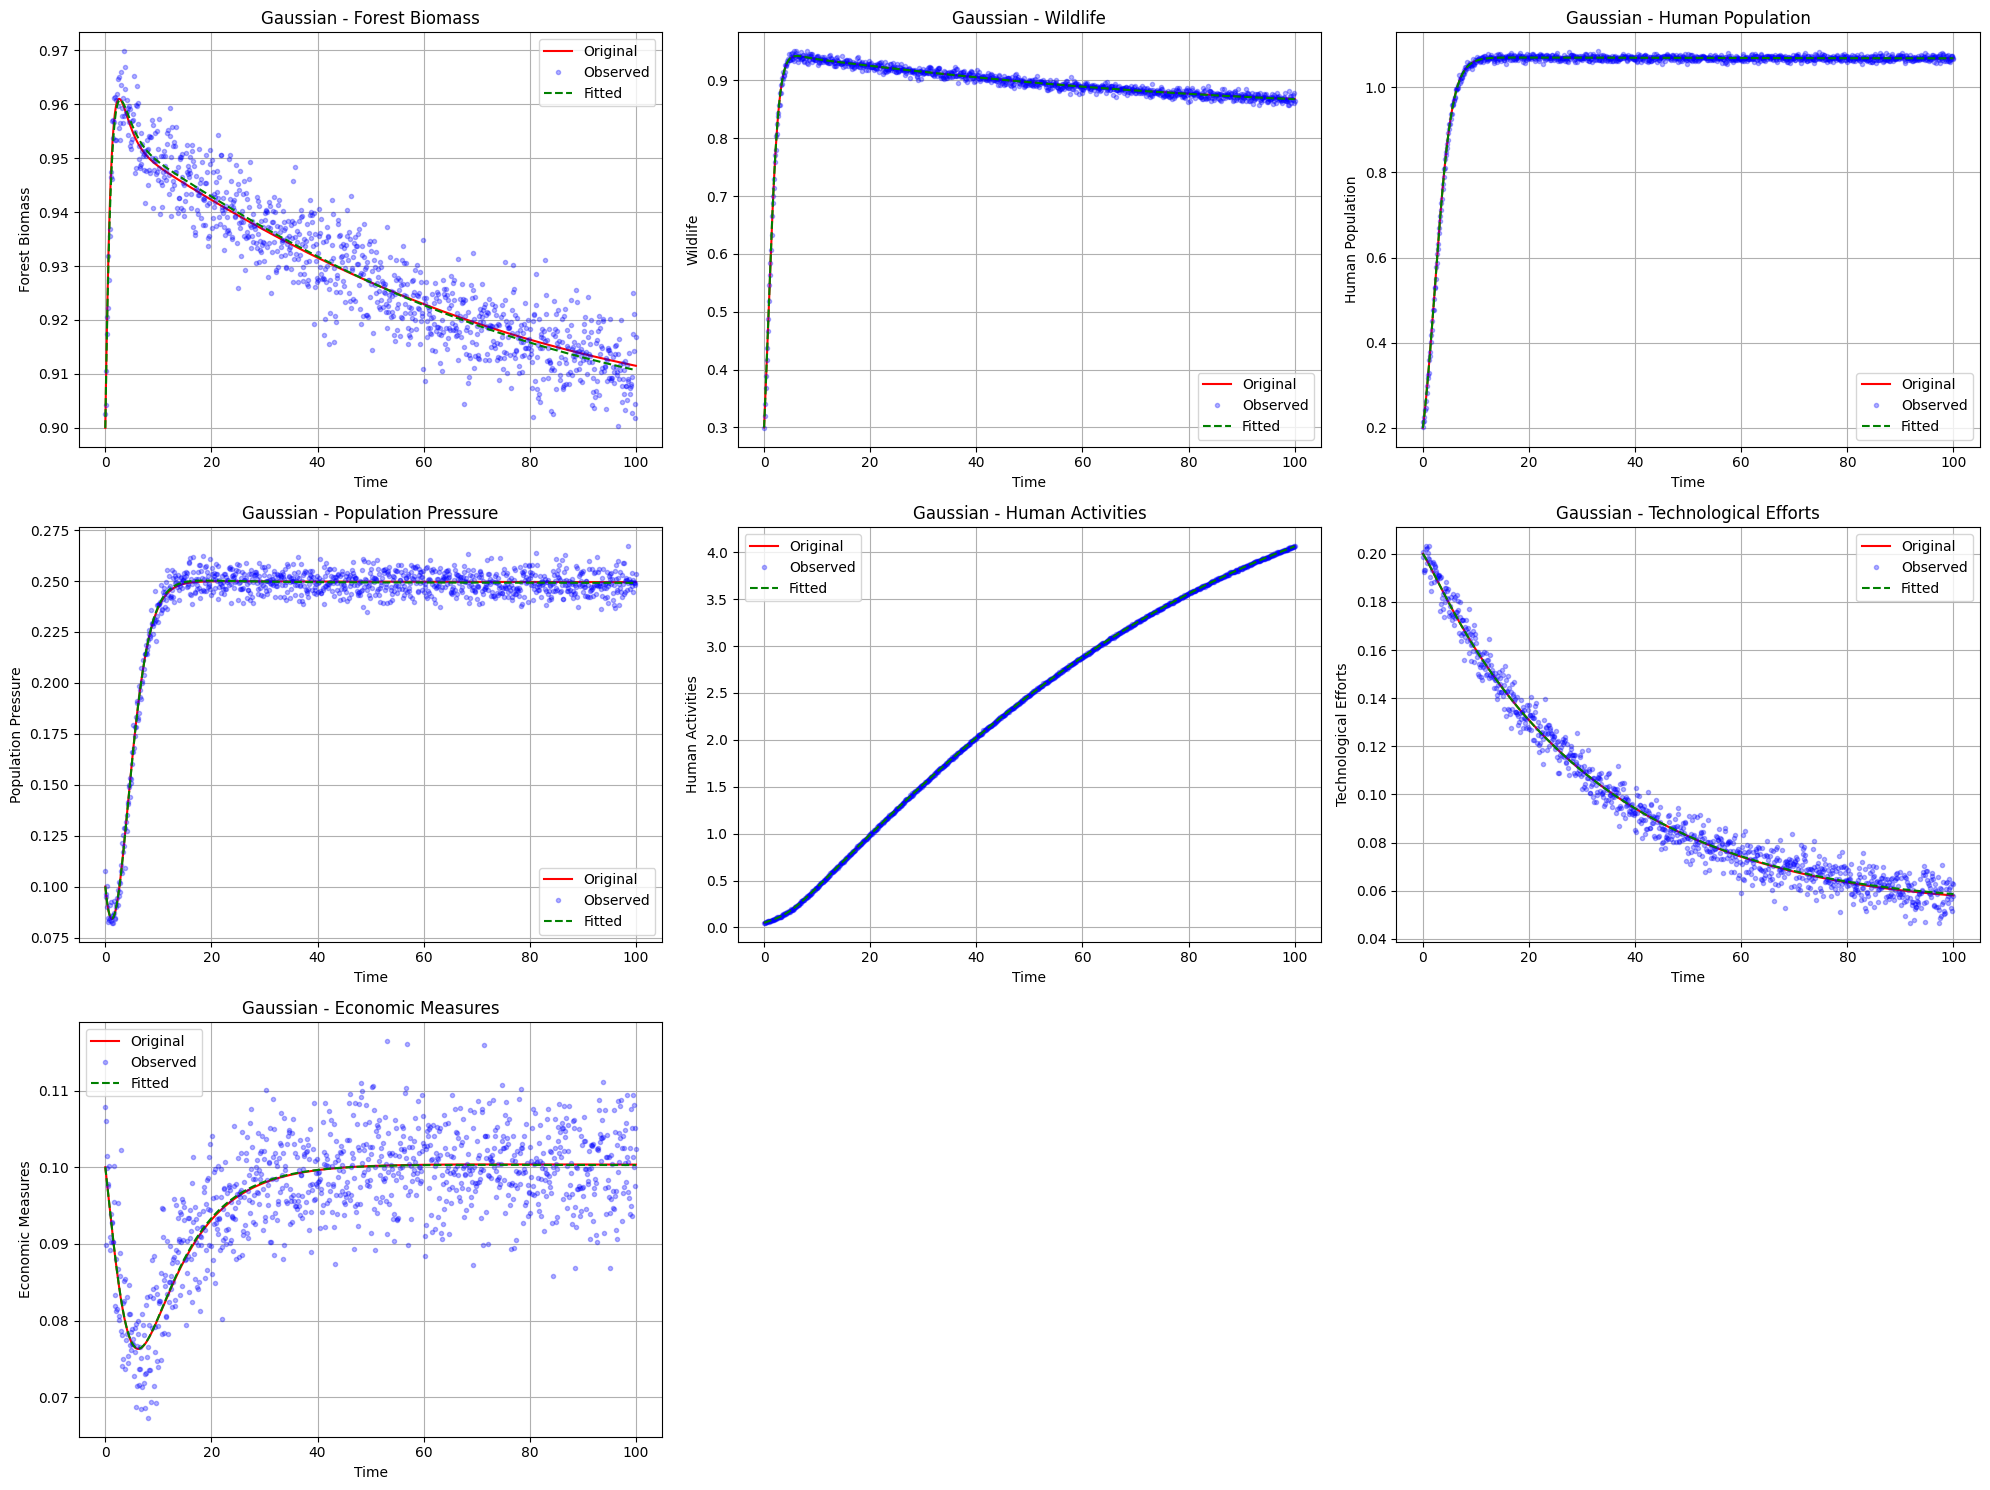

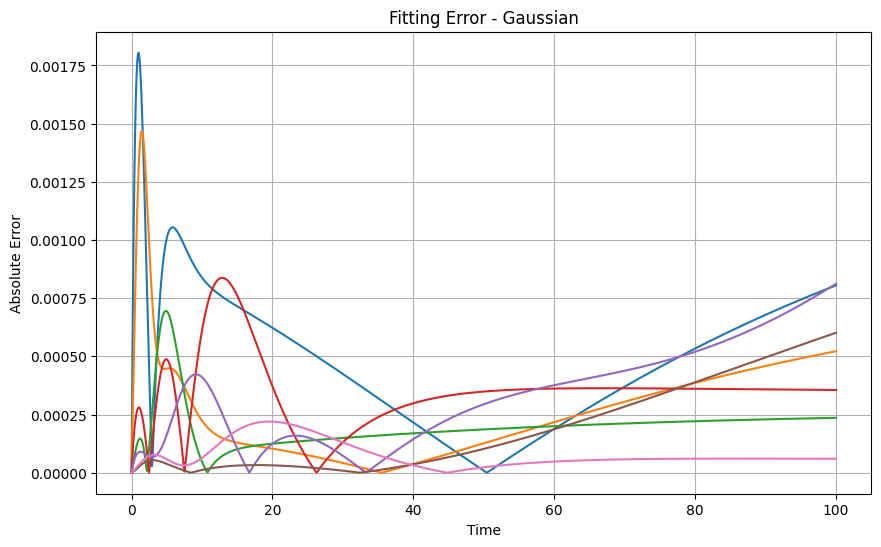

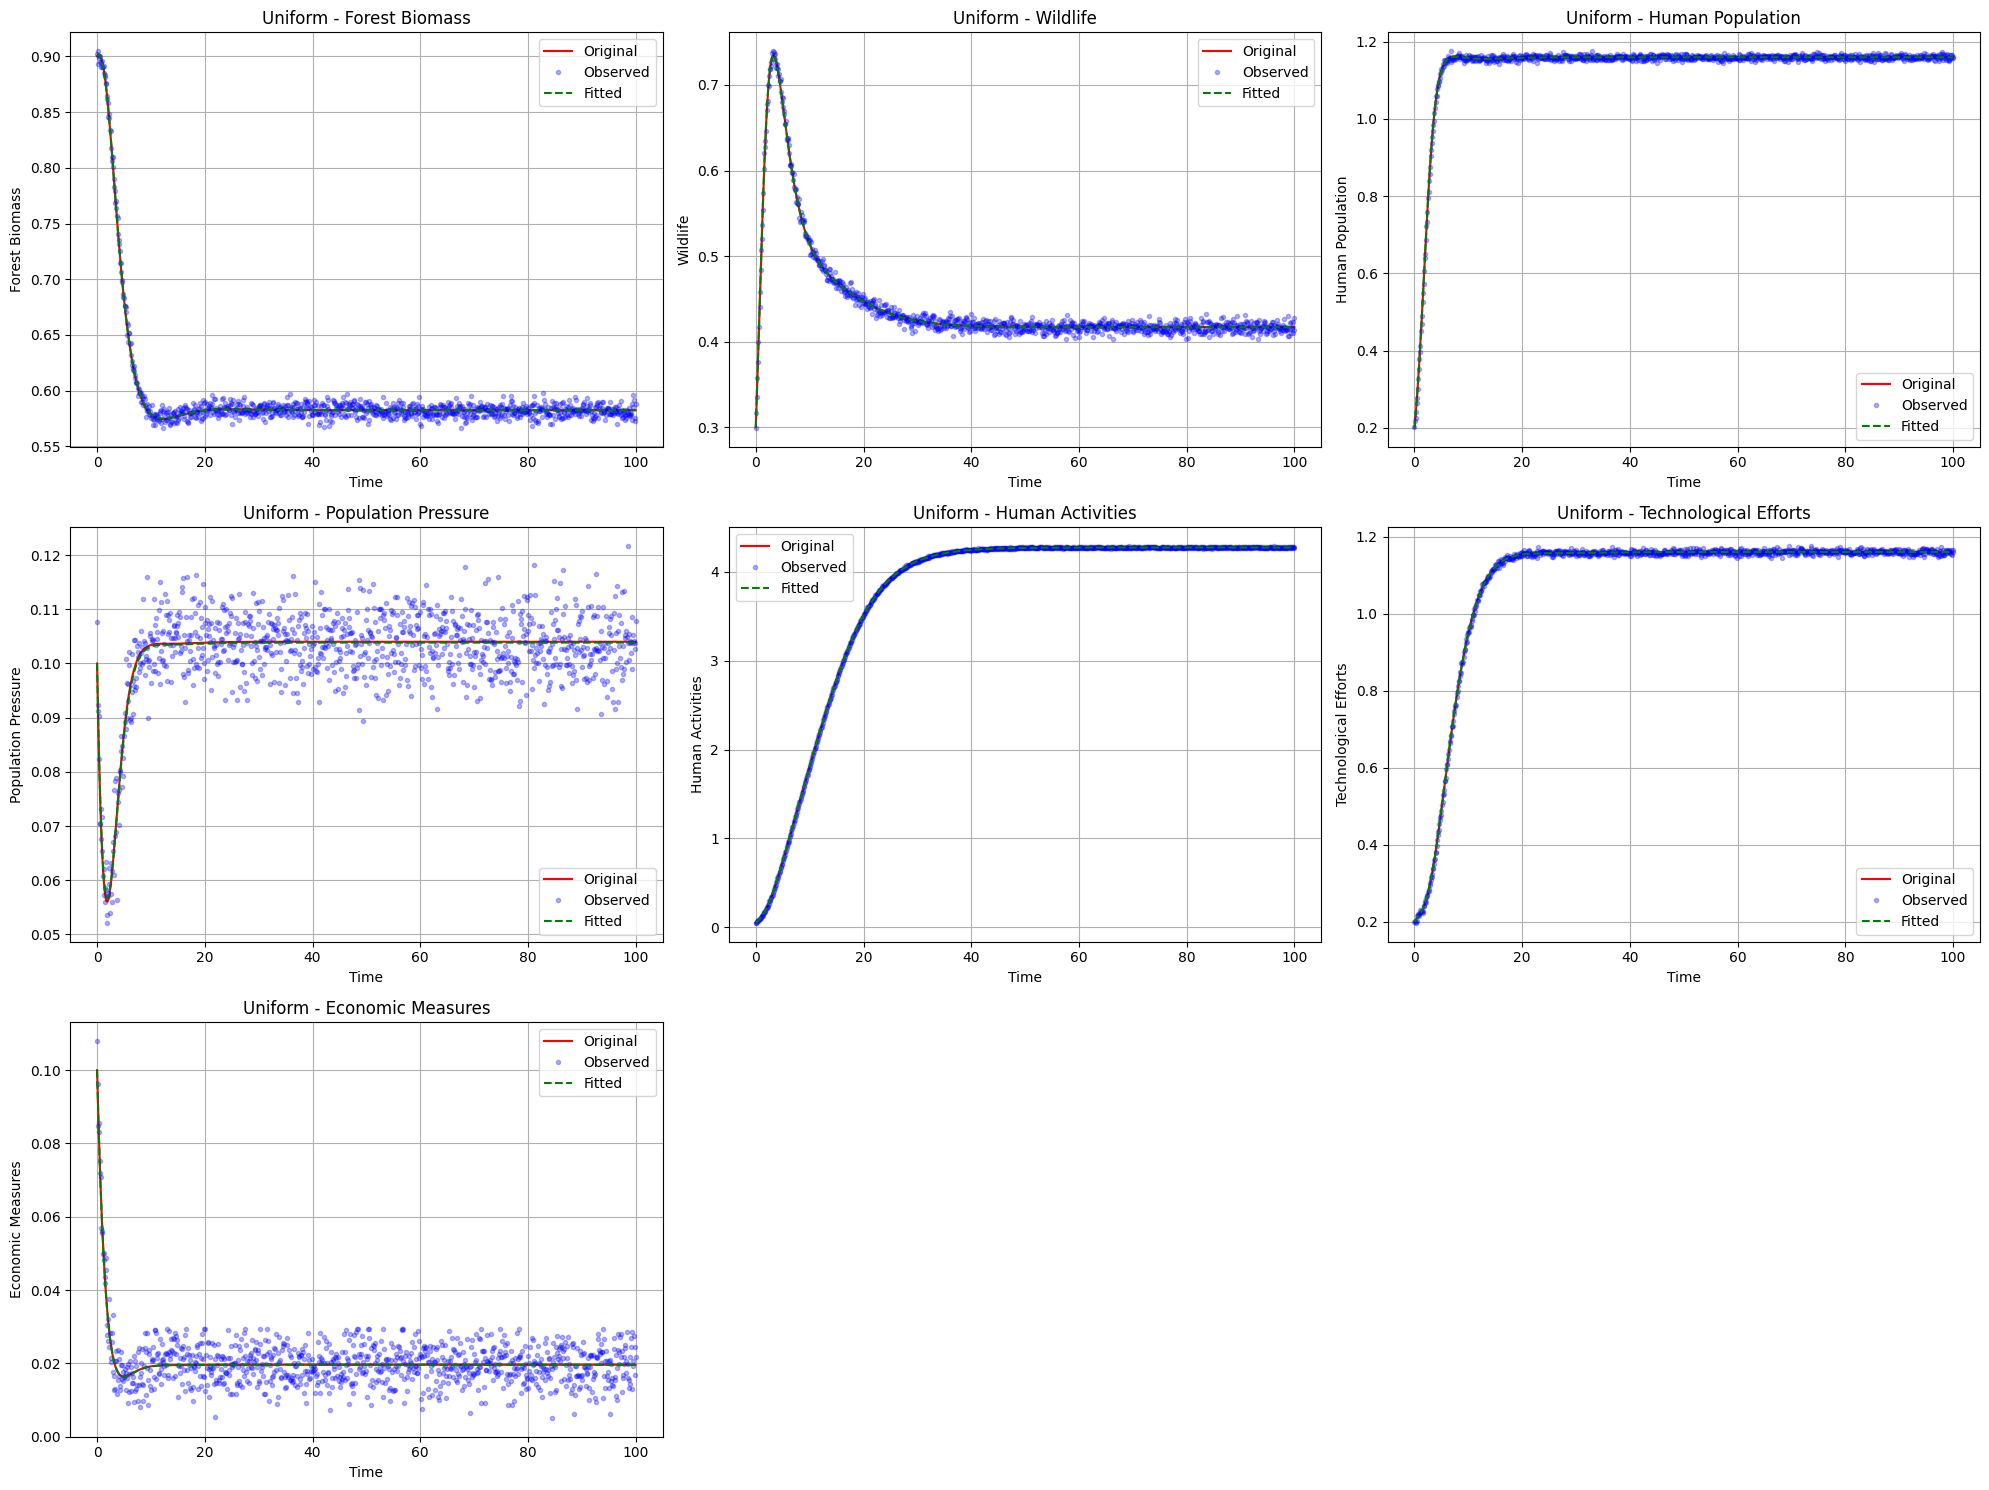

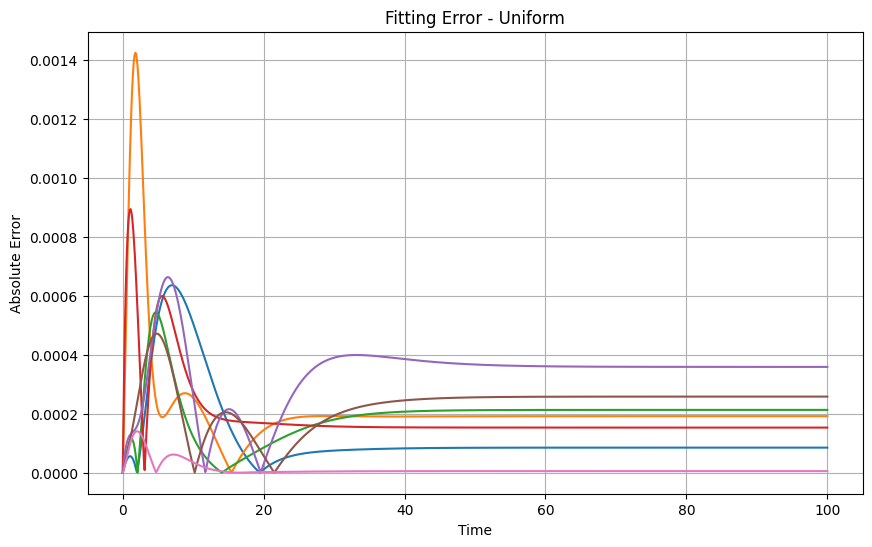

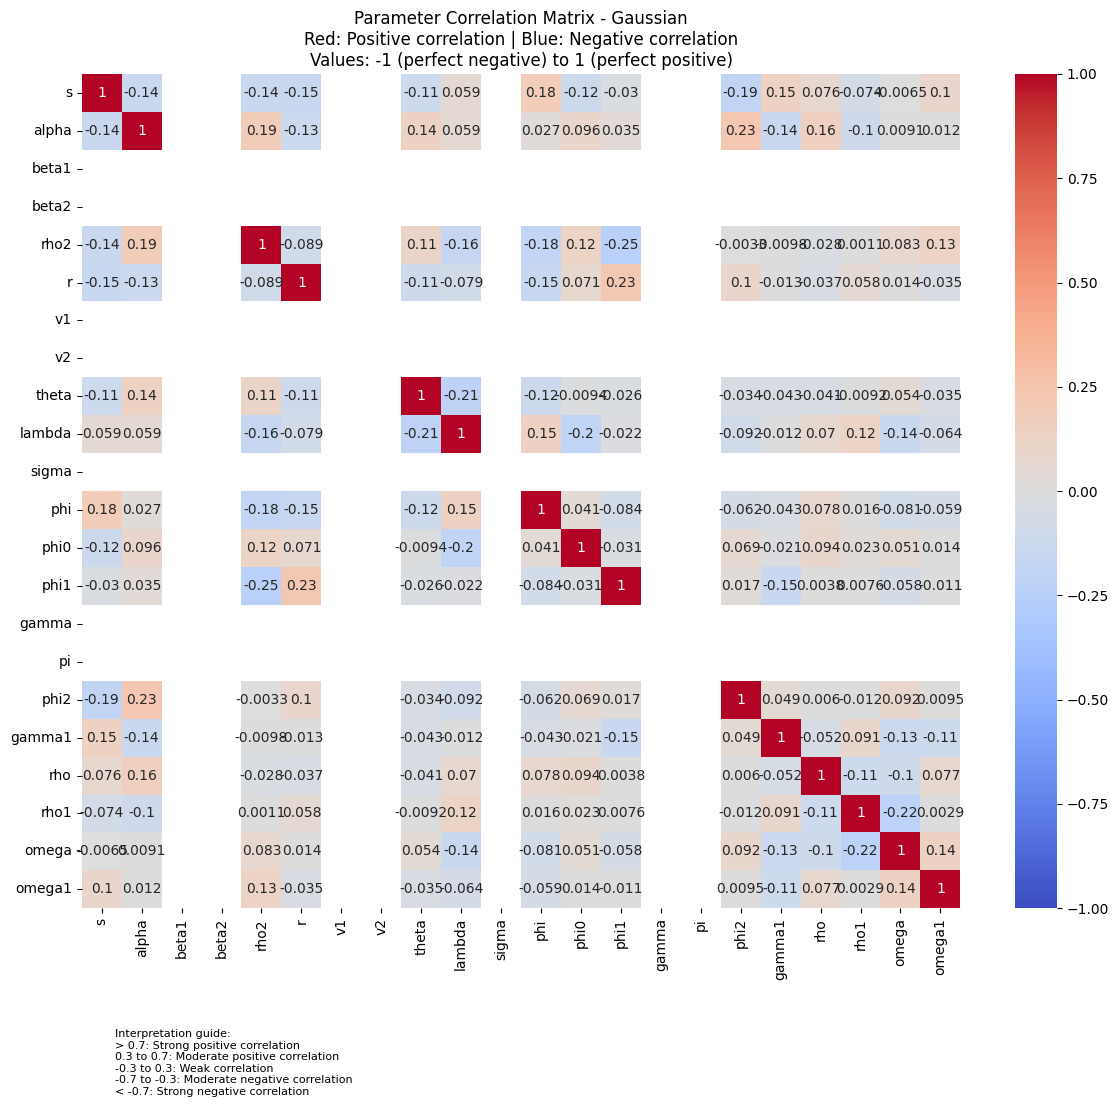

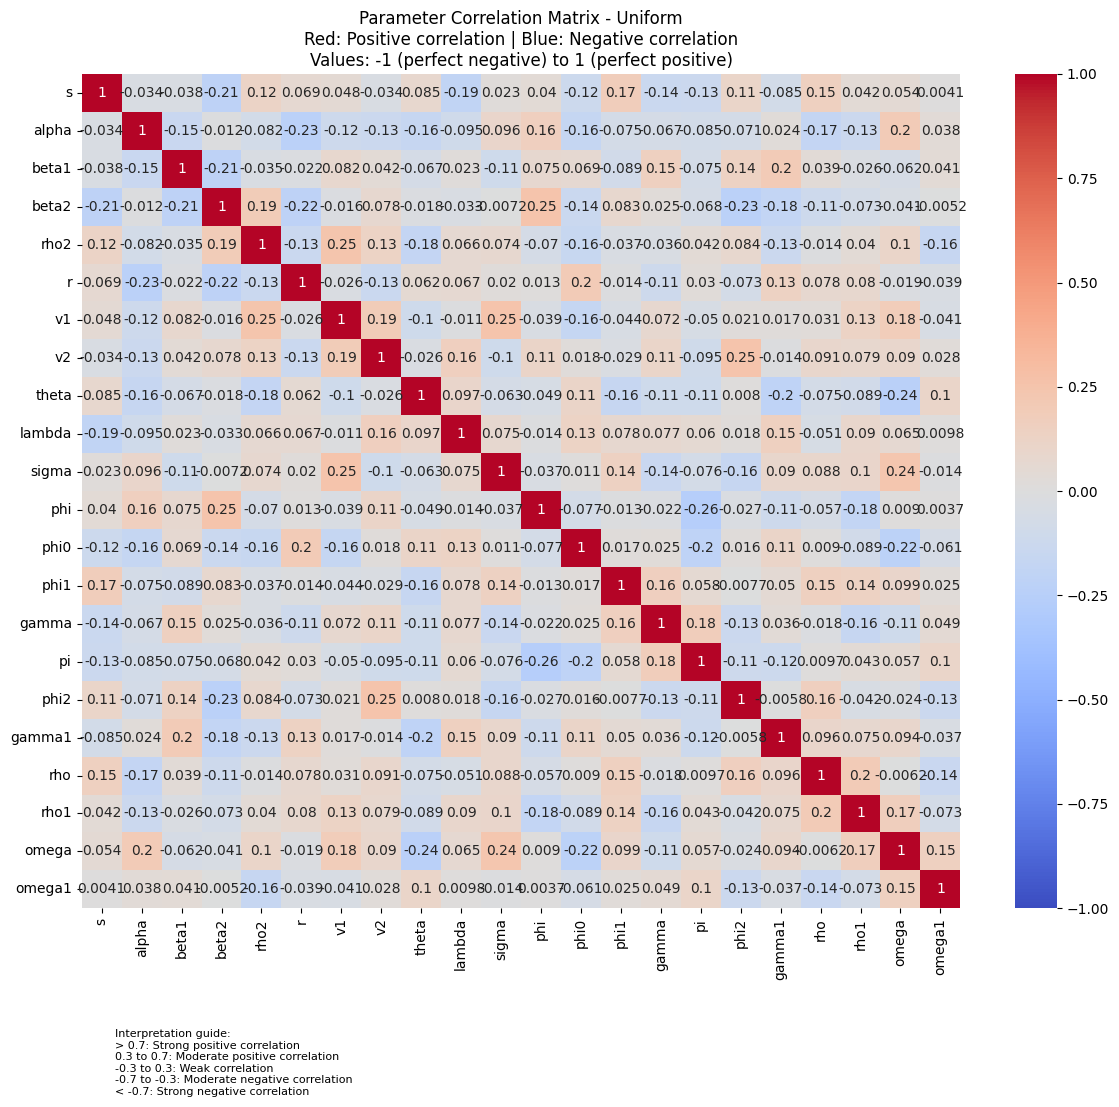

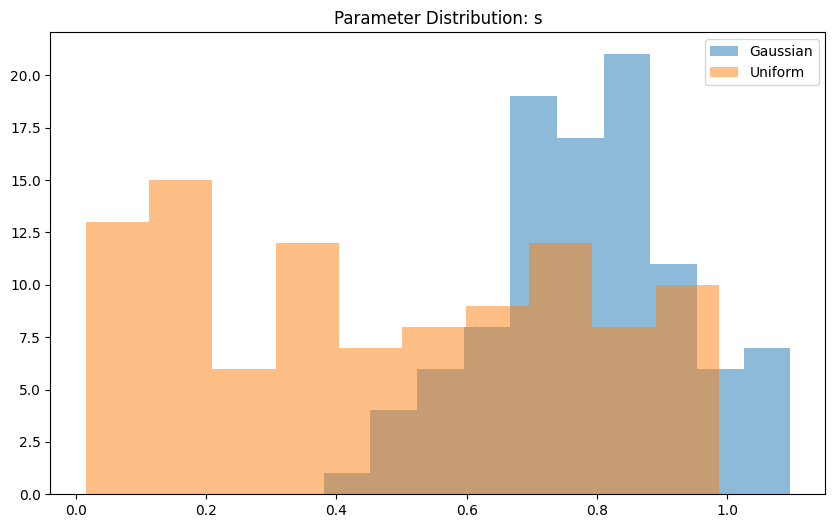

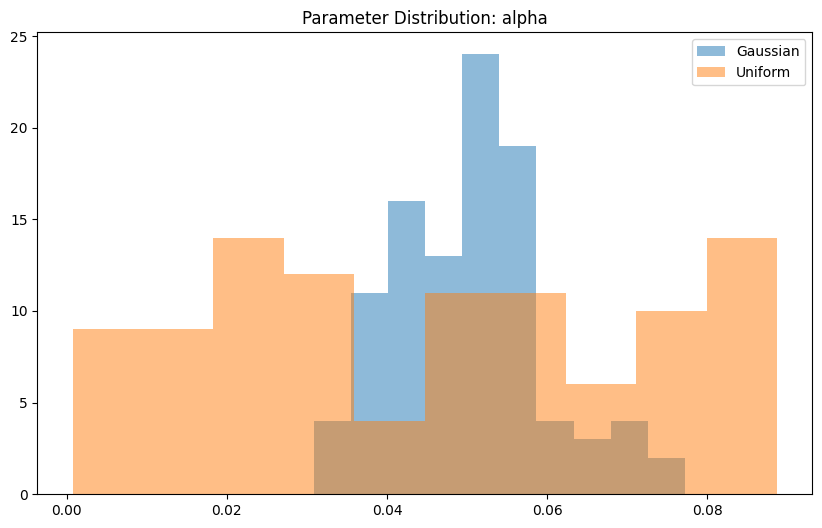

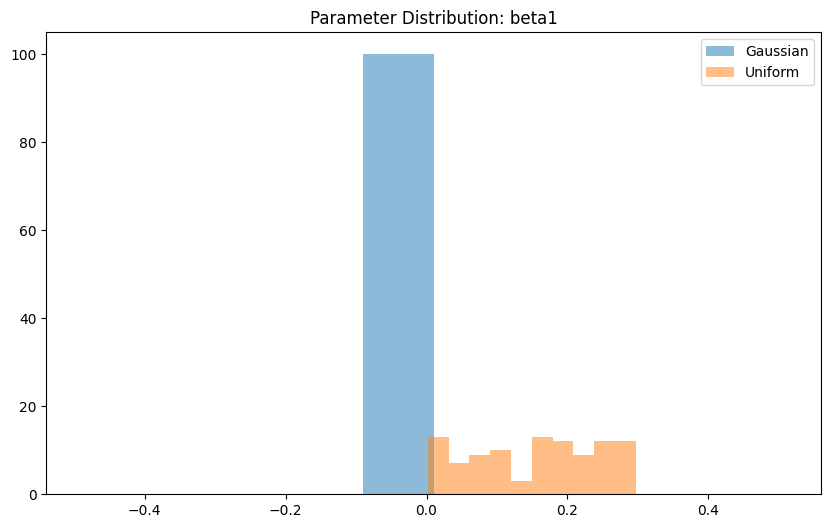

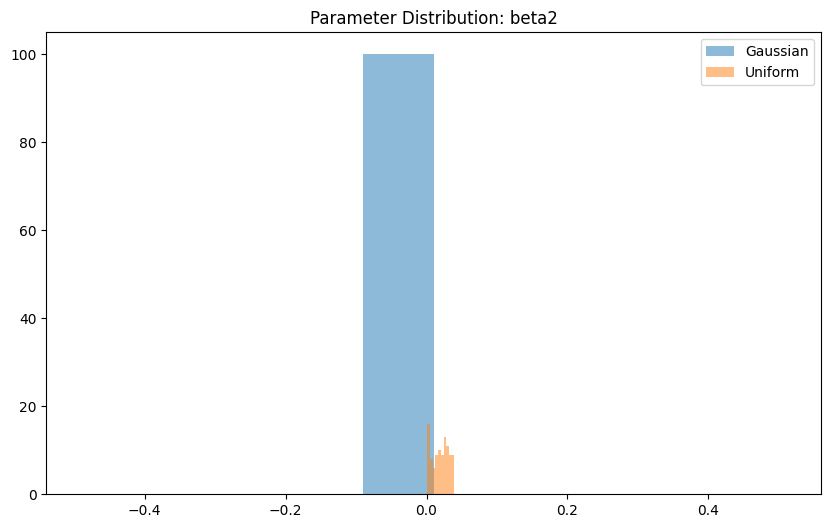

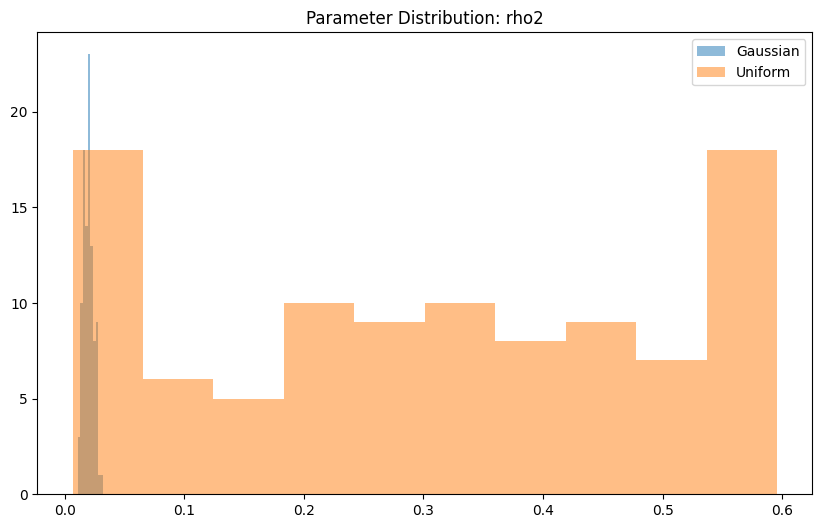

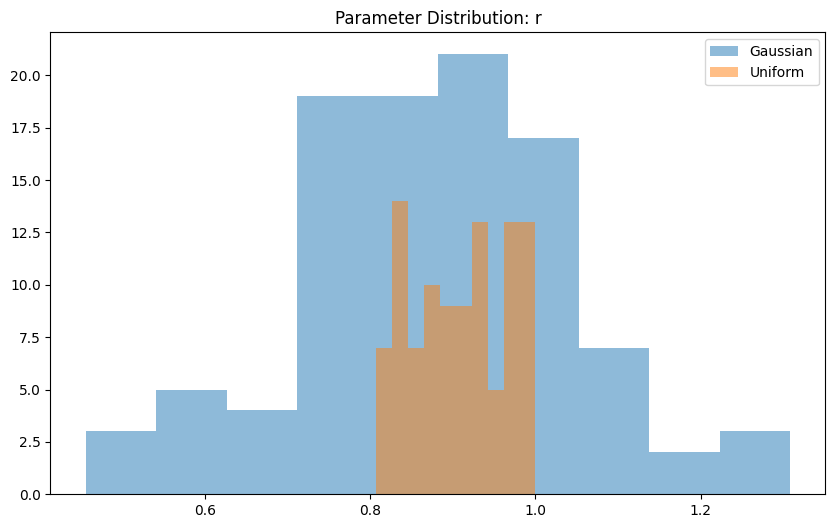

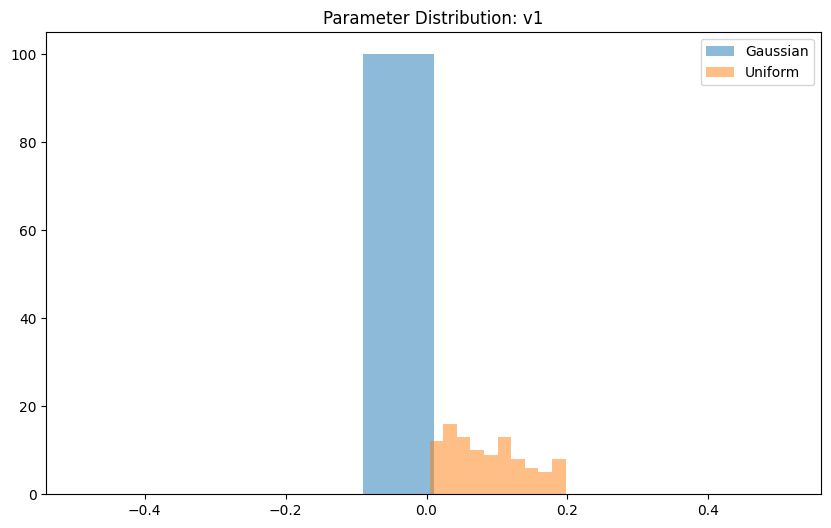

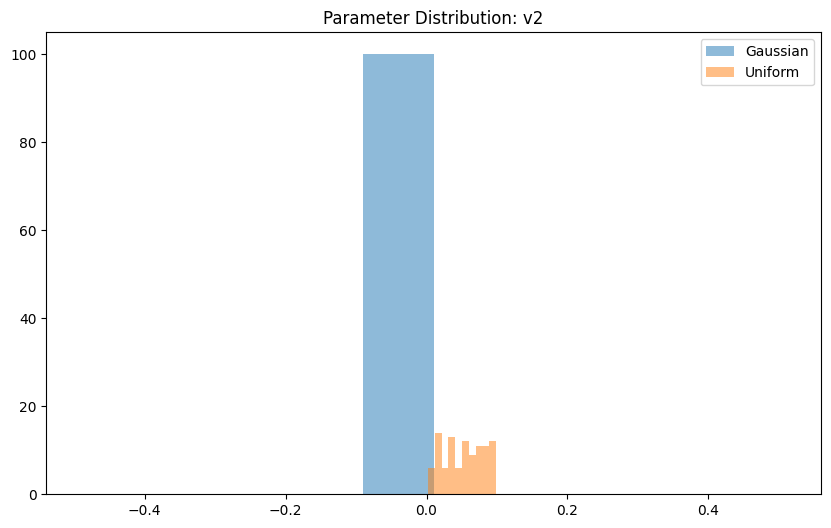

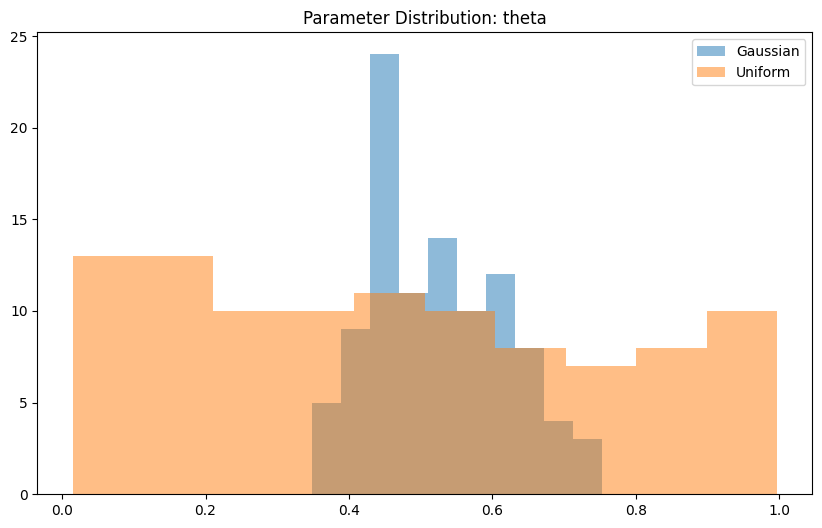

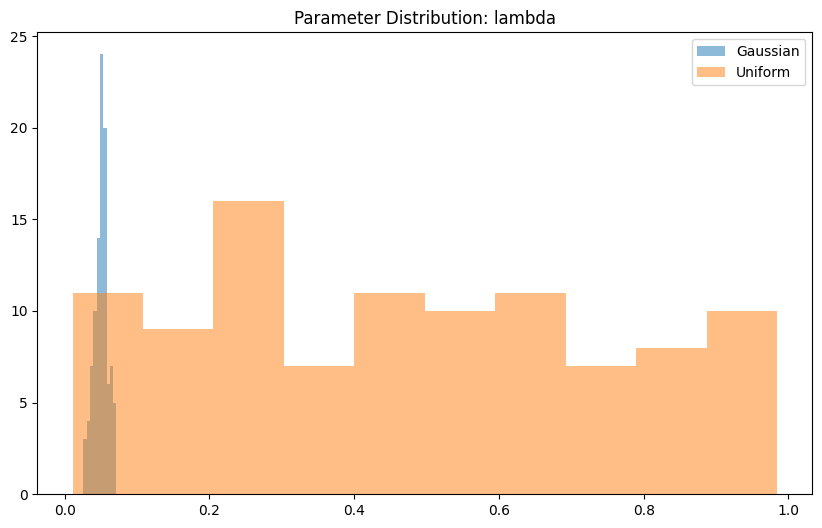

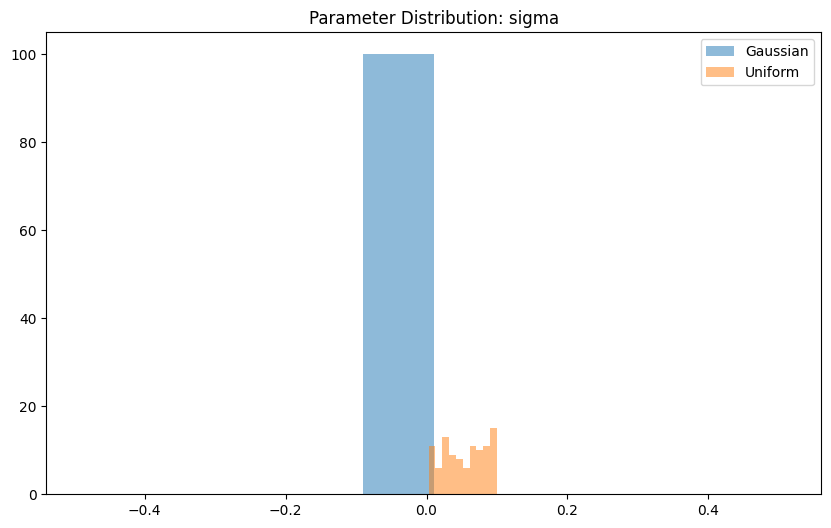

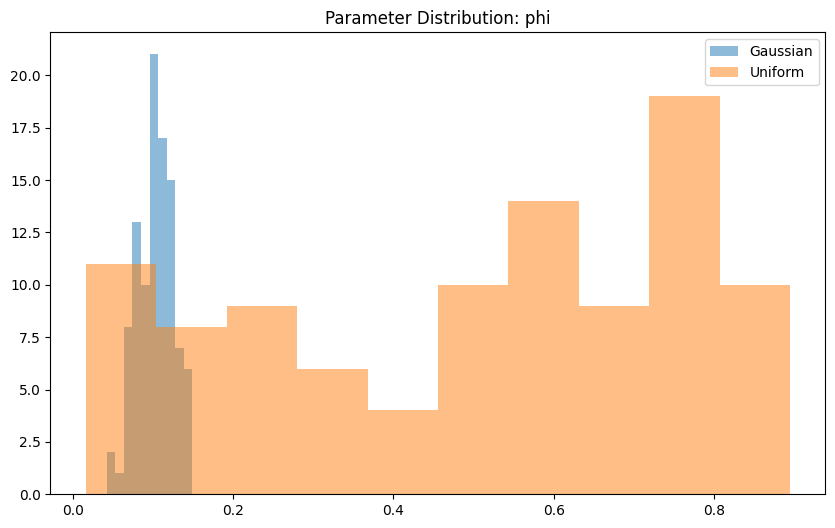

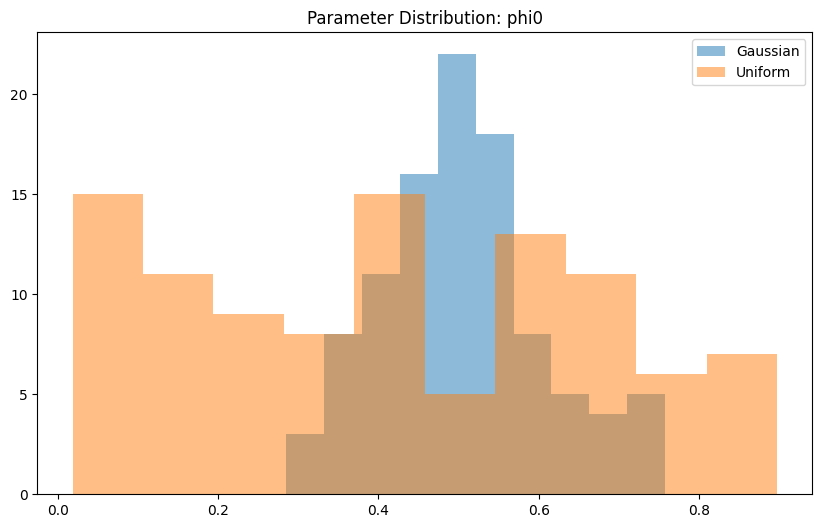

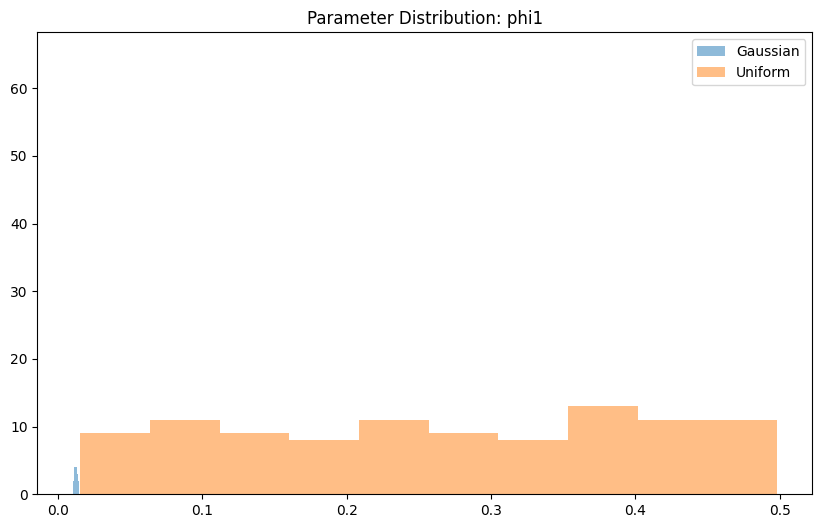

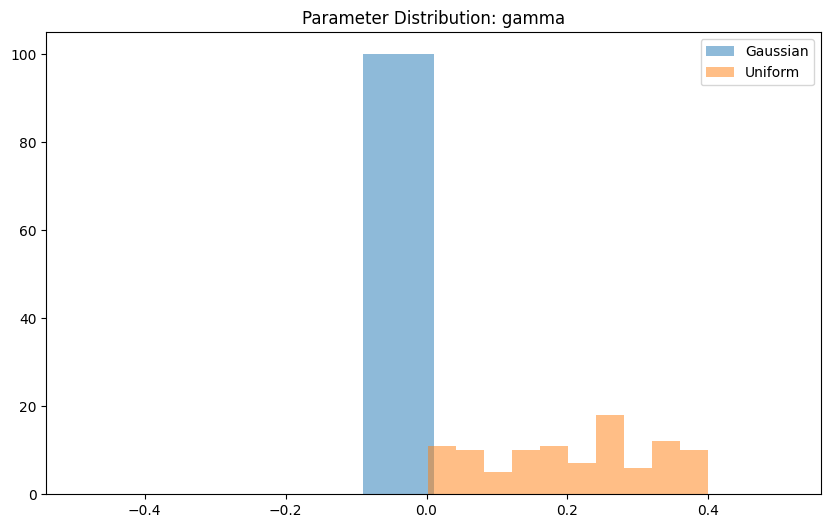

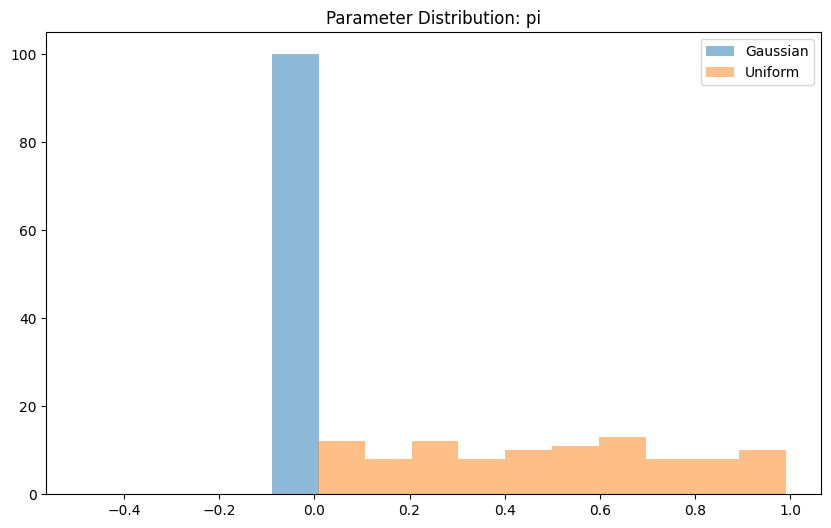

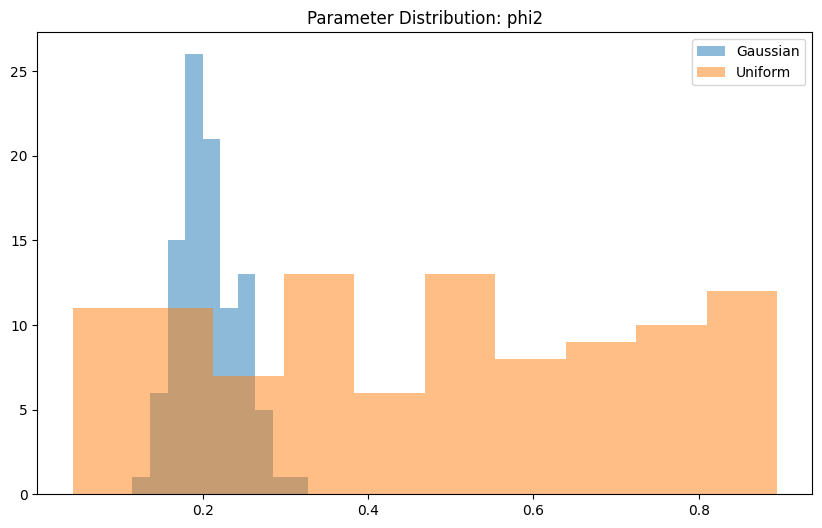

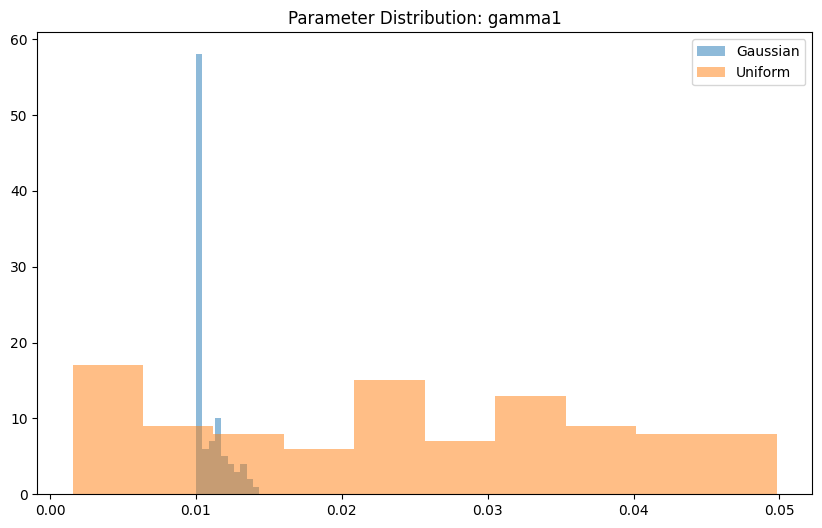

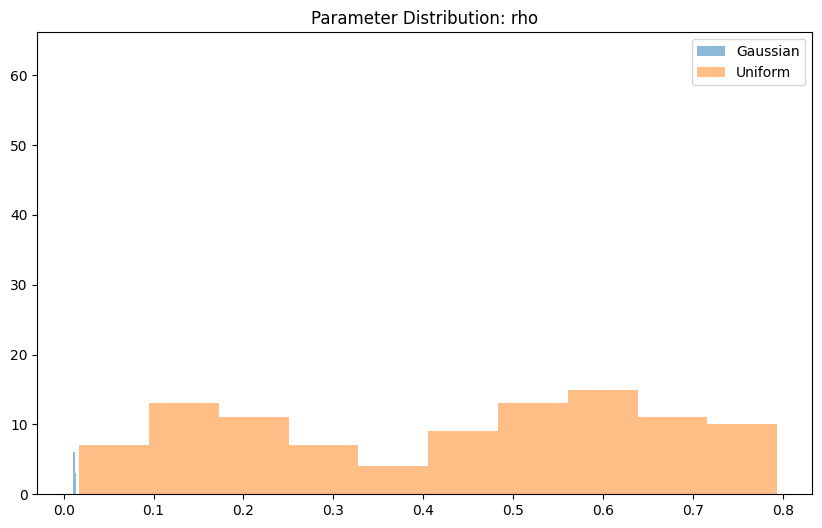

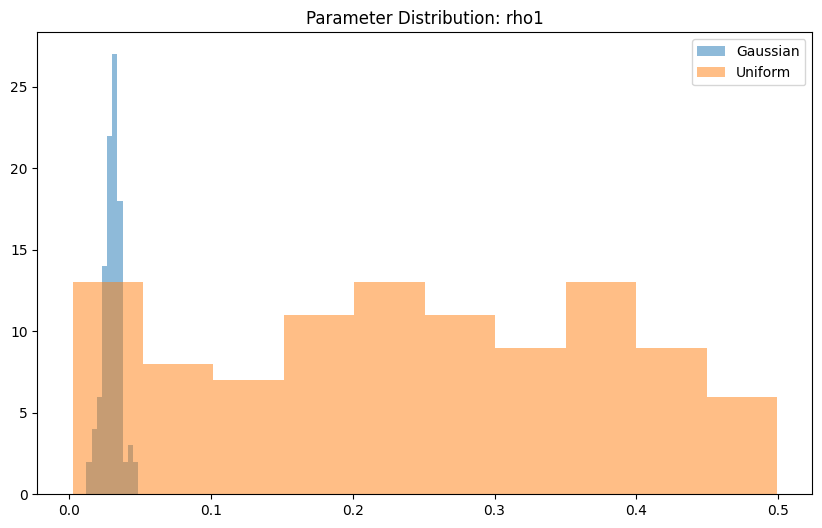

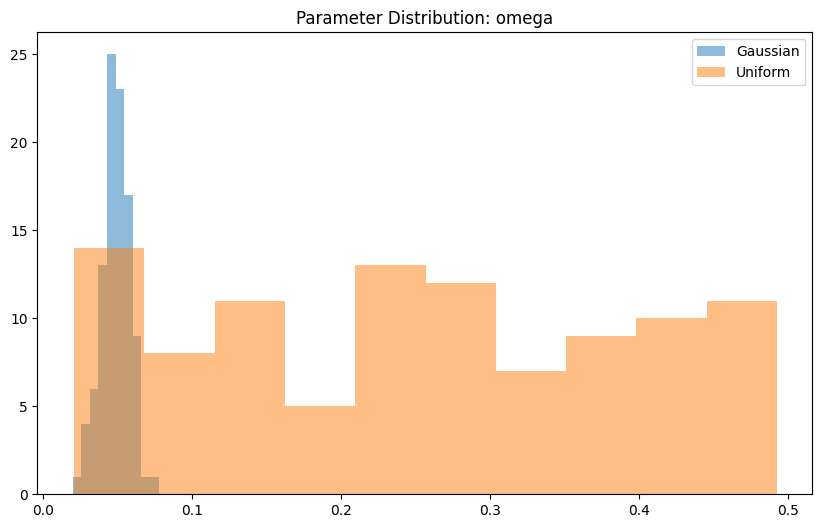

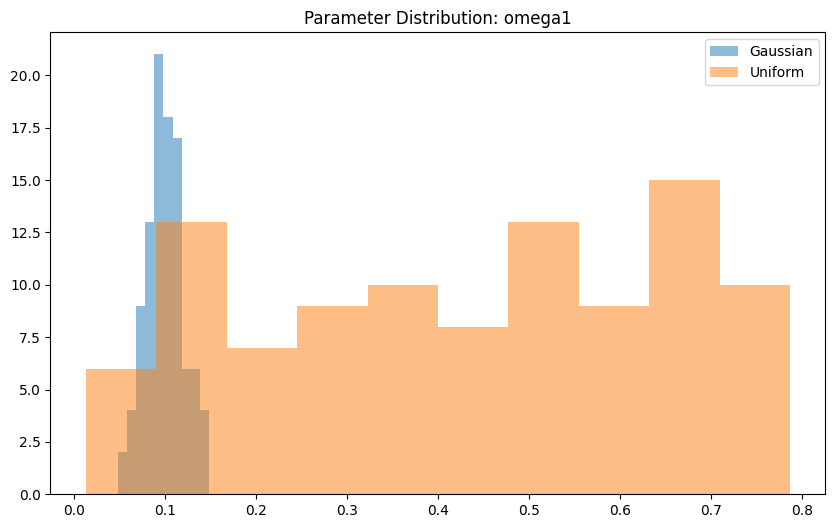


Metrics Comparison:

Gaussian:
MSE: 0.000000
RMSE: 0.000350
MAE: 0.000268
R2: 1.000000

Uniform:
MSE: 0.000000
RMSE: 0.000234
MAE: 0.000185
R2: 1.000000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import least_squares

def model_forest_biomass(X, t, params):
    """Model diferensial untuk dinamika biomassa hutan dengan batasan"""
    Y = np.zeros(7)
    
    # Unpack parameters
    s, alpha, beta1, beta2, rho2, r, v1, v2, theta, \
    lambda_, sigma, phi, phi0, phi1, gamma, pi, \
    phi2, gamma1, rho, rho1, omega, omega1 = params
    
    # Sistem persamaan diferensial
    Y[0] = s*X[0]*(1 - X[0]) - alpha*X[0]*X[1] - beta1*X[0]*X[2] - beta2*X[0]*X[0]*X[4] + rho2*X[0]*X[5]
    Y[1] = r*X[1]*(1 - X[1]/X[0]) - v1*X[1]*X[2] - v2*X[1]*X[4]
    Y[2] = theta*X[2]*(1 - X[2]) + lambda_*X[0]*X[2] - sigma*X[2]*X[1]
    Y[3] = phi*X[2] - phi0*X[3] - phi1*X[3]*X[6]
    Y[4] = gamma*X[2] + pi*X[0]*X[0]*X[4]*(1 - X[4]/5.0) + phi2*X[3] - gamma1*X[4]  # Batas aktivitas manusia
    Y[5] = rho*(1 - X[0]) - rho1*X[5] + 0.1*X[6]*X[5]  # Pengaruh ekonomi ke teknologi
    Y[6] = omega*X[3] - omega1*X[6]
    
    return Y

def safe_divide(a, b, eps=1e-10):
    """Fungsi untuk mencegah pembagian dengan nol"""
    return a / (b + eps)

def generate_gaussian_params(n_samples=100):
    """Generate synthetic parameter data using Gaussian distribution"""
    np.random.seed(42)
    
    # Parameter berdasarkan literatur ilmiah
    param_means = [
        0.8,    # s      [7] Lata et al. (2018)
        0.05,   # alpha  [13] Jyotsna & Tandon (2017)
        0.003,  # beta1  [20] Pathak et al. (2021)
        0.0004, # beta2  Assumed
        0.02,   # rho2   [11] Misra & Lata (2015)
        0.9,    # r      [13] Jyotsna & Tandon (2017)
        0.002,  # v1     [20] Pathak et al. (2021)
        0.0001, # v2     [20] Pathak et al. (2021)
        0.5,    # theta  [20] Pathak et al. (2021)
        0.05,   # lambda [20] Pathak et al. (2021)
        0.001,  # sigma  [20] Pathak et al. (2021)
        0.1,    # phi    [11] Misra & Lata (2015)
        0.5,    # phi0   [11] Misra & Lata (2015)
        0.01,   # phi1   [37] Misra et al. (2014)
        0.004,  # gamma  Assumed
        0.002,  # pi     [20] Pathak et al. (2021)
        0.2,    # phi2   Assumed
        0.01,   # gamma1 [20] Pathak et al. (2021)
        0.01,   # rho    [38,11] Misra & Lata (2013,2015)
        0.03,   # rho1   [38,11] Misra & Lata (2013,2015)
        0.05,   # omega  [37] Misra et al. (2014)
        0.1     # omega1 [11] Misra & Lata (2015)
    ]
    
    param_stds = [mean * 0.2 for mean in param_means]  # standar deviasi 20% dari mean
    
    params_data = np.zeros((n_samples, len(param_means)))
    for i in range(len(param_means)):
        params_data[:, i] = np.maximum(0.01, np.random.normal(
            param_means[i], 
            param_stds[i], 
            n_samples
        ))
    
    param_names = [
        's', 'alpha', 'beta1', 'beta2', 'rho2',
        'r', 'v1', 'v2', 'theta', 'lambda',
        'sigma', 'phi', 'phi0', 'phi1', 'gamma',
        'pi', 'phi2', 'gamma1', 'rho',
        'rho1', 'omega', 'omega1'
    ]
    
    return pd.DataFrame(params_data, columns=param_names)

def generate_uniform_params(n_samples=100):
    """Generate synthetic parameter data using Uniform distribution"""
    np.random.seed(42)
    
    # Range parameter berdasarkan literatur
    param_ranges = [
        (0.01, 1.0),      # s      - Natural decay rate [7]
        (0.0001, 0.09),   # alpha  - Impact of wildlife [13]
        (0.0001, 0.3),    # beta1  - Human population impact [20]
        (0.0005, 0.04),   # beta2  - Human activities impact
        (0.0001, 0.6),    # rho2   - Technology impact on biomass [11]
        (0.8045, 1.0),    # r      - Wildlife growth rate [13]
        (0.0002, 0.2),    # v1     - Human impact on wildlife [20]
        (0.00002, 0.1),   # v2     - Activity impact on wildlife [20]
        (0.01, 1.0),      # theta  - Human population growth [20]
        (0.0, 1.0),       # lambda - Resource availability [20]
        (0.001, 0.1),     # sigma  - Wildlife impact on humans [20]
        (0.01, 0.9),      # phi    - Population pressure growth [11]
        (0.01, 0.9),      # phi0   - Natural decay of pressure [11]
        (0.0001, 0.5),    # phi1   - Economic impact on pressure [37]
        (0.0001, 0.4),    # gamma  - Human activities growth
        (0.0, 1.0),       # pi     - Resource conversion rate [20]
        (0.02, 0.9),      # phi2   - Pressure impact on activities
        (0.001, 0.05),    # gamma1 - Activities decay rate [20]
        (0.01, 0.8),      # rho    - Technology growth rate [38,11]
        (0.001, 0.5),     # rho1   - Technology decay rate [38,11]
        (0.01, 0.5),      # omega  - Economic growth rate [37]
        (0.003, 0.8)      # omega1 - Economic decay rate [11]
    ]
    
    params_data = np.zeros((n_samples, len(param_ranges)))
    
    for i in range(len(param_ranges)):
        params_data[:, i] = np.random.uniform(
            param_ranges[i][0],
            param_ranges[i][1],
            n_samples
        )
    
    param_names = [
        's', 'alpha', 'beta1', 'beta2', 'rho2',
        'r', 'v1', 'v2', 'theta', 'lambda',
        'sigma', 'phi', 'phi0', 'phi1', 'gamma',
        'pi', 'phi2', 'gamma1', 'rho',
        'rho1', 'omega', 'omega1'
    ]
    
    return pd.DataFrame(params_data, columns=param_names), param_ranges

def objective_function(params, t, observed_data):
    """Fungsi objektif untuk optimasi dengan penanganan error"""
    try:
        X0 = [0.9, 0.3, 0.2, 0.1, 0.05, 0.2, 0.1]  # Initial conditions yang lebih realistis
        solution = odeint(model_forest_biomass, X0, t, args=(tuple(params),))
        residuals = solution - observed_data
        # Ganti nilai tidak terhingga dengan nilai besar
        residuals[~np.isfinite(residuals)] = 1e6
        return np.ravel(residuals)
    except:
        # Return nilai besar jika terjadi error
        return np.ones(len(t) * 7) * 1e6

def calculate_fitting_metrics(original, fitted):
    """Menghitung metrik kualitas fitting"""
    mse = np.mean((original - fitted)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(original - fitted))
    r2 = 1 - np.sum((original - fitted)**2) / np.sum((original - np.mean(original))**2)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

def plot_fitting_error(t, original, fitted, method_name):
    """Plot error fitting"""
    error = np.abs(original - fitted)
    plt.figure(figsize=(10, 6))
    plt.plot(t, error)
    plt.title(f'Fitting Error - {method_name}')
    plt.xlabel('Time')
    plt.ylabel('Absolute Error')
    plt.grid(True)
    plt.show()

def plot_parameter_correlation(params, method_name):
    """Plot correlation matrix parameter dengan anotasi"""
    corr = params.corr()
    plt.figure(figsize=(12, 10))
    
    # Plot heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    
    # Tambah anotasi interpretasi
    plt.title(f'Parameter Correlation Matrix - {method_name}\n' + 
             'Red: Positive correlation | Blue: Negative correlation\n' +
             'Values: -1 (perfect negative) to 1 (perfect positive)')
    
    # Tambah penjelasan di bawah plot
    plt.figtext(0.1, -0.1, 
                'Interpretation guide:\n' +
                '> 0.7: Strong positive correlation\n' +
                '0.3 to 0.7: Moderate positive correlation\n' +
                '-0.3 to 0.3: Weak correlation\n' +
                '-0.7 to -0.3: Moderate negative correlation\n' +
                '< -0.7: Strong negative correlation',
                fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_parameter_distributions(gaussian_params, uniform_params):
    """Plot perbandingan distribusi parameter"""
    for param in gaussian_params.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(gaussian_params[param], alpha=0.5, label='Gaussian')
        plt.hist(uniform_params[param], alpha=0.5, label='Uniform')
        plt.title(f'Parameter Distribution: {param}')
        plt.legend()
        plt.show()

def plot_with_confidence(solutions, times, variable_idx, method_name):
    """Plot time series dengan confidence interval"""
    mean = np.mean(solutions, axis=0)
    std = np.std(solutions, axis=0)
    plt.fill_between(times, mean-2*std, mean+2*std, alpha=0.2)
    plt.plot(times, mean, label=f'{method_name} Mean')

def run_analysis():
    """Fungsi utama untuk menjalankan analisis"""
    # Set parameter simulasi
    t = np.linspace(0, 100, 1000)
    X0 = [0.9, 0.3, 0.2, 0.1, 0.05, 0.2, 0.1]  # Initial conditions yang lebih realistis
    
    # Generate parameter
    gaussian_params = generate_gaussian_params(n_samples=100)
    uniform_params, param_ranges = generate_uniform_params(n_samples=100)
    
    # Simulasi untuk kedua metode
    results = {}
    for method, params in [("Gaussian", gaussian_params.iloc[0].values),
                         ("Uniform", uniform_params.iloc[0].values)]:
        # Generate solusi original
        original_solution = odeint(model_forest_biomass, X0, t, args=(tuple(params),))
        
        # Tambah noise
        np.random.seed(42)
        noise_level = 0.005  # Kurangi noise level
        observed_data = np.maximum(0, np.minimum(
            original_solution + noise_level * np.random.randn(*original_solution.shape),
            1.5 * original_solution  # Batasi maksimum noise
        ))
        
        # Fitting
        result = least_squares(
            objective_function, 
            params, 
            args=(t, observed_data),
            bounds=([1e-6]*len(params), [10.0]*len(params)),
            method='trf',
            loss='soft_l1',
            ftol=1e-8,
            xtol=1e-8,
            max_nfev=2000  # Tambah iterasi maksimum
        )
        
        fitted_solution = odeint(model_forest_biomass, X0, t, args=(tuple(result.x),))
        
        # Hitung metrics
        metrics = calculate_fitting_metrics(original_solution, fitted_solution)
        
        # Plot hasil
        variables = ['Forest Biomass', 'Wildlife', 'Human Population', 
                    'Population Pressure', 'Human Activities',
                    'Technological Efforts', 'Economic Measures']
        
        plt.figure(figsize=(20, 15))
        for i in range(7):
            plt.subplot(3, 3, i+1)
            plt.plot(t, original_solution[:, i], 'r-', label='Original')
            plt.plot(t, observed_data[:, i], 'b.', label='Observed', alpha=0.3)
            plt.plot(t, fitted_solution[:, i], 'g--', label='Fitted')
            plt.xlabel('Time')
            plt.ylabel(variables[i])
            plt.title(f'{method} - {variables[i]}')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Plot error
        plot_fitting_error(t, original_solution, fitted_solution, method)
        
        # Simpan hasil
        results[method] = {
            'original': original_solution,
            'observed': observed_data,
            'fitted': fitted_solution,
            'metrics': metrics,
            'params': result.x
        }
    
    # Plot correlation matrix
    plot_parameter_correlation(gaussian_params, "Gaussian")
    plot_parameter_correlation(uniform_params, "Uniform")
    
    # Plot parameter distributions
    plot_parameter_distributions(gaussian_params, uniform_params)
    
    # Print metrics comparison
    print("\nMetrics Comparison:")
    for method in results:
        print(f"\n{method}:")
        for metric, value in results[method]['metrics'].items():
            print(f"{metric}: {value:.6f}")

if __name__ == "__main__":
    run_analysis()